# BoneFractureYolo8 Dataset

In [177]:
import kagglehub
import yaml
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import plotly.express as px
from shapely.geometry import Polygon
import shutil

import gc
gc.collect()

29235

## Descarga

Descargamos dataset y guardamos la ruta de los datos.

In [178]:
data_path = os.path.abspath("./data")

dl_path = None
if not os.path.exists(data_path):
    url = "pkdarabi/bone-fracture-detection-computer-vision-project"
    dl_path = kagglehub.dataset_download(url)
    print(f"Data downloaded at {dl_path}")
else:
    print(f"Data is at {data_path}")
    
if dl_path:
    shutil.move(dl_path, data_path)
    print(f"Data moved to {data_path}")
    
dl_path = data_path

100%|██████████| 84.1M/84.1M [00:02<00:00, 30.0MB/s]

Extracting files...


Data downloaded at /Users/jcarmona/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2
Data moved to /Users/jcarmona/Repos/in-progress/KSchool-TFM/data


Visualizamos contenido de descarga.

In [179]:
print(os.path.basename(dl_path))
for dirpath, dirnames, filenames in os.walk(dl_path):
    level = dirpath.replace(dl_path, "").count(os.sep)
    indent = "   " * (level - 1) + "|__"
    dirname = os.path.basename(dirpath)
    if dirpath != dl_path:
        print(f"{indent}{dirname}")
    if len(filenames) > 0:
        indent = "   " * (level) + "|__"
        if len(filenames) > 1 and len(set([os.path.splitext(f)[-1] for f in filenames])) == 1:
            print(f"{indent}{filenames[0]}\n{indent}...")
        else:
            for f in filenames:
                print(f"{indent}{f}")

data
|__BoneFractureYolo8
   |__README.dataset.txt
   |__data.yaml
   |__valid
      |__images
         |__image1_96_png.rf.84e1d4c27219711b3bab09d6f54745b0.jpg
         |__...
      |__labels
         |__image1_947_png.rf.c09499f3067dd00d1e9fe5c6ea497ff2.txt
         |__...
   |__test
      |__images
         |__image1_704_png.rf.e3668d404753b933e1fd9500e697ca8c.jpg
         |__...
      |__labels
         |__image1_1588_png.rf.aba29f401dee4db13fc5434f3c0186b4.txt
         |__...
   |__train
      |__images
         |__image1_273_png.rf.f022d65b5a20cc363d04891eabb54357.jpg
         |__...
      |__labels
         |__image1_473_png.rf.b7a84b4bb51b15c207c71805a5b476c3.txt
         |__...
|__bone fracture detection.v4-v4.yolov8
   |__README.dataset.txt
   |__data.yaml
   |__valid
      |__images
         |__image1_96_png.rf.84e1d4c27219711b3bab09d6f54745b0.jpg
         |__...
      |__labels
         |__image1_947_png.rf.c09499f3067dd00d1e9fe5c6ea497ff2.txt
         |__...
   |__test
   

## Análisis de datos

In [180]:
data_path = os.path.join(dl_path, "BoneFractureYolo8")

with open(os.path.join(data_path, "data.yaml"), "r") as f:
    data_yaml = yaml.safe_load(f)
    
data_yaml

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 7,
 'names': ['elbow positive',
  'fingers positive',
  'forearm fracture',
  'humerus fracture',
  'humerus',
  'shoulder fracture',
  'wrist positive'],
 'roboflow': {'workspace': 'veda',
  'project': 'bone-fracture-detection-daoon',
  'version': 4,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4'}}

In [181]:
with open(os.path.join(data_path, "README.dataset.txt"), "r") as f:
    data_readme = f.read()
    
print(data_readme)

# Bone Fracture Detection 
Provided by a Roboflow user
License: CC BY 4.0




### EDA
Analizamos los datos en un `dataFrame` para comprender la estructura y distribución del dataset utilizado para la detección de fracturas.

#### Obtención de datos

In [182]:
yolo=False

class_names = {i: d for i, d in enumerate(data_yaml["names"])}
max_idx = max(class_names.keys())


def build_item(subset: str, name: str, h: int, w: int, labels: list=None):
    _class = int(l[0]) if labels else np.nan
    if np.isnan(float(_class)):
        class_name = "-"
    elif _class > max_idx:
        class_name = f"class_{_class}"
    else:
        class_name = class_names[_class]
        
    return {
        "subset": subset,
        "name": name,
        "height": h,
        "width": w,
        "class": _class,
        "class_name": class_name,
        "bbox": [float(l) for l in labels[1:]] if labels else []
    }

data_df = []
for s in ["train", "valid", "test"]:
    
    images_filenames = sorted(os.listdir(os.path.join(data_path, s, "images")))
    labels_filenames = sorted(os.listdir(os.path.join(data_path, s, "labels")))
    print(f"Images: {len(images_filenames)}, Labels: {len(labels_filenames)}")
    
    for img_fn, l_fn in zip(images_filenames, labels_filenames):
        if (name := os.path.splitext(img_fn)[0]) != os.path.splitext(l_fn)[0]:
            print(f"Do not match {s}: img={img_fn}, label={l_fn}")
        
        image = cv2.imread(os.path.join(data_path, s, "images", img_fn))
        h, w = image.shape[:2]
        
        with open(os.path.join(data_path, s, "labels", l_fn), "r") as f:
            labels = f.readlines()
            
        if len(labels) == 0:
            data_df.append(build_item(s, name, h, w))
        else:
            for l in labels:
                data_df.append(build_item(s, name, h, w, l.split(" ")))
                
df = pd.DataFrame(data_df)
df.sample(5)

Images: 3631, Labels: 3631
Images: 348, Labels: 348
Images: 169, Labels: 169


,subset,name,height,width,class,class_name,bbox
1163,train,image1_223_png.rf.fa81606b5e9827529ed2a06c9f57...,512,380,NaN,-,[]
1929,train,image1_363_png.rf.aff0bfe667751e45518b20f82166...,512,420,NaN,-,[]
4246,valid,image2_1224_png.rf.7c20f6876b3efc39ea916cda7db...,512,424,4.0,humerus,"[0.4485848624751253, 0.20156250149011612, 0.64..."
175,train,image1_1118_png.rf.6ad67c69227a6e7c23347fdedc2...,512,397,NaN,-,[]
2690,train,image1_546_png.rf.e1d7b5acceb24daba542f5a84814...,512,248,NaN,-,[]


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476 entries, 0 to 4475
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   subset      4476 non-null   object 
 1   name        4476 non-null   object 
 2   height      4476 non-null   int64  
 3   width       4476 non-null   int64  
 4   class       2388 non-null   float64
 5   class_name  4476 non-null   object 
 6   bbox        4476 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 244.9+ KB


In [184]:
df.describe()

,height,width,class
count,4476.000000,4476.00000,2388.000000
mean,485.900357,409.81613,2.665829
std,79.005672,114.59419,2.077603
min,134.000000,111.00000,0.000000
25%,494.000000,379.00000,1.000000
50%,512.000000,420.00000,2.000000
75%,512.000000,512.00000,5.000000
max,2048.000000,2048.00000,6.000000


Existen exactamente las clases señalizadas en el `.yaml`, por lo que no faltan datos ni existen erróneos. Transformaremos el dataset para trabajar con él.

In [185]:
df["subset"] = df["subset"].astype("category")
df["name"] = df["name"].astype("string")
df["class"] = df["class"].astype(np.float16)
df["class_name"] = df["class_name"].astype("category")
df["height"] = df["height"].astype(np.uint16)
df["width"] = df["width"].astype(np.uint16)

df.loc[df["class"]==-1, "class"] = np.nan

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476 entries, 0 to 4475
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   subset      4476 non-null   category
 1   name        4476 non-null   string  
 2   height      4476 non-null   uint16  
 3   width       4476 non-null   uint16  
 4   class       2388 non-null   float16 
 5   class_name  4476 non-null   category
 6   bbox        4476 non-null   object  
dtypes: category(2), float16(1), object(1), string(1), uint16(2)
memory usage: 105.5+ KB


In [187]:
df.describe()

,height,width,class
count,4476.000000,4476.00000,2388.000000
mean,485.900357,409.81613,2.666016
std,79.005672,114.59419,2.078125
min,134.000000,111.00000,0.000000
25%,494.000000,379.00000,1.000000
50%,512.000000,420.00000,2.000000
75%,512.000000,512.00000,5.000000
max,2048.000000,2048.00000,6.000000


#### Distribución del dataset

In [188]:
fig = px.pie(
    df.groupby("subset", observed=True)["name"].nunique().sort_values(ascending=False).reset_index(name="count"),
    names="subset",
    values="count",
    title="Distribución por subconjunto",
    labels={"subset": "Subconjunto", "count": "Número de imágenes"},
    hole=0.4
)
fig.show()

In [189]:
fig = px.pie(
    df.groupby("subset", observed=True)["class_name"].value_counts().sort_values(ascending=False).reset_index(),
    names="class_name",
    values="count",
    labels={"class_name": "Clase", "count": "Frecuencia"},
    title="Frecuencia de clases por subjunto",
    color="class_name",
    facet_col="subset",
    hole=0.4
)
fig.show()

In [190]:
fig = px.pie(
    df.drop_duplicates(["name"]).groupby("subset", observed=True)["class"]\
        .apply(lambda x: x.notna().value_counts()).reset_index().sort_values("class", ascending=False),
    names="test",
    values="class",
    labels={"test": "¿Tiene anotaciones?", "class": "Número de imágenes"},
    title="Número de imágenes con/sin anotación por subconjunto",
    facet_col="subset"
)
fig.update_xaxes(tickvals=[True, False], ticktext=["Sí", "No"])
fig.show()

#### Dimensión de imágenes

In [191]:
fig = px.scatter(
    df.sort_values("class_name"),
    x="width",
    y="height",
    color="class_name",
    hover_name="name",
    hover_data=["class_name"],
    title="Distribución de dimensiones (anchura vs altura) por subconjunto",
    labels={"width": "Anchura", "height": "Altura"},
    opacity=0.7,
    facet_col="subset"
)
fig.show()

In [192]:
fig = px.box(
    df.melt(id_vars=["name", "subset"], value_vars=["height", "width"],
            var_name="axis", value_name="value"),
    x="axis",
    y="value",
    points="outliers",
    hover_name="name",
    labels={"axis": "Dimensión", "value": "Tamaño"},
    title="Boxplot de dimensiones (altura y anchura) por subset",
    color="axis",
    facet_col="subset"
)
fig.show()

In [193]:
fig = px.histogram(
    df[["subset", "height", "width"]].melt(id_vars="subset", var_name="axis", value_name="value"),
    x="value",
    color="axis",
    barmode="overlay",
    nbins=100,
    title="Distribución de height y width",
    labels={"axis": "Valor (pixeles)", "value":"Frecuencia"},
    opacity=0.5
)
fig.show()

In [194]:
fig = px.box(
    df,
    x="class_name",
    y="height",
    points="outliers",
    hover_name="name",
    labels={"class_name": "Clases", "height": "Altura"},
    title="Boxplot de **altura** por clase y subconjunto",
    color="class_name",
    facet_col="subset"
)
fig.show()

In [195]:
fig = px.box(
    df,
    x="class_name",
    y="width",
    points="outliers",
    hover_name="name",
    labels={"class_name": "Clases", "width": "Anchura"},
    title="Boxplot de **anchura** por clase y subconjunto",
    color="class_name",
    facet_col="subset"
)
fig.show()

In [196]:
df["aspect_ratio"] = df["width"] / df["height"]

fig = px.histogram(
    df[["subset", "aspect_ratio"]],
    x="aspect_ratio",
    nbins=100,
    title="Distribución de relaciones de aspecto (width / height)",
    opacity=0.5,
    color="subset"
)
fig.update_layout(xaxis_title="Relación de Aspecto", yaxis_title="Frecuencia")
fig.show()

In [197]:
fig = px.box(
    df.sort_values("class_name"),
    x="class_name",
    y="aspect_ratio",
    points="outliers",
    hover_name="name",
    labels={"aspect_ratio": "Relación de Aspecto"},
    title="Boxplot de relaciones de aspecto por clase y subjunto",
    color="class_name",
    facet_col="subset"
)
fig.show()

In [198]:
df.head()

/Users/jcarmona/Repos/in-progress/KSchool-TFM/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

overflow encountered in cast



,subset,name,height,width,class,class_name,bbox,aspect_ratio
0,train,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,1024,1024,0.0,elbow positive,"[0.35585933923721313, 0.3968750014901161, 0.45...",1.0
1,train,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,1024,1024,0.0,elbow positive,"[0.458736435546875, 0.3806510419921875, 0.3614...",1.0
2,train,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,1024,1024,0.0,elbow positive,"[0.4779147490234375, 0.3756653818359375, 0.380...",1.0
3,train,elbow-dislocation-with-coronoid-process-fractu...,2048,2048,0.0,elbow positive,"[0.37971050146484375, 0.417125080078125, 0.326...",1.0
4,train,elbow-dislocation-with-coronoid-process-fractu...,2048,2048,0.0,elbow positive,"[0.3167693330078125, 0.5993769916992188, 0.370...",1.0


#### Inspección de anotaciones (bounding boxes)

In [199]:
df_boxes = df[df["class"].notna()].copy()
yolo = all(df_boxes["bbox"].apply(lambda x: len(x) == 4))
yolo

False

In [200]:
if yolo:
    df_boxes["x_center"] = df_boxes["bbox"].apply(lambda b: b[0])
    df_boxes["y_center"] = df_boxes["bbox"].apply(lambda b: b[1])
    df_boxes["width"] = df_boxes["bbox"].apply(lambda b: b[2])
    df_boxes["height"] = df_boxes["bbox"].apply(lambda b: b[3])
else:
    df_boxes["xs"] = df_boxes["bbox"].apply(lambda b: np.array(b)[::2])
    df_boxes["ys"] = df_boxes["bbox"].apply(lambda b: np.array(b)[1::2])
    
df_boxes.head()

/Users/jcarmona/Repos/in-progress/KSchool-TFM/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

overflow encountered in cast



,subset,name,height,width,class,class_name,bbox,aspect_ratio,xs,ys
0,train,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,1024,1024,0.0,elbow positive,"[0.35585933923721313, 0.3968750014901161, 0.45...",1.0,"[0.35585933923721313, 0.4525467435362568, 0.45...","[0.3968750014901161, 0.3829741733292004, 0.473..."
1,train,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,1024,1024,0.0,elbow positive,"[0.458736435546875, 0.3806510419921875, 0.3614...",1.0,"[0.458736435546875, 0.3614540244140625, 0.3689...","[0.3806510419921875, 0.389472591796875, 0.4823..."
2,train,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,1024,1024,0.0,elbow positive,"[0.4779147490234375, 0.3756653818359375, 0.380...",1.0,"[0.4779147490234375, 0.3804500517578125, 0.373...","[0.3756653818359375, 0.369160001953125, 0.4620..."
3,train,elbow-dislocation-with-coronoid-process-fractu...,2048,2048,0.0,elbow positive,"[0.37971050146484375, 0.417125080078125, 0.326...",1.0,"[0.37971050146484375, 0.3261278564453125, 0.38...","[0.417125080078125, 0.6149684370117188, 0.6657..."
4,train,elbow-dislocation-with-coronoid-process-fractu...,2048,2048,0.0,elbow positive,"[0.3167693330078125, 0.5993769916992188, 0.370...",1.0,"[0.3167693330078125, 0.37067339990234377, 0.55...","[0.5993769916992188, 0.6550453393554687, 0.547..."


###### Polygon?

In [201]:
if not yolo:
    print(
        f"X Vs Y: {(df_boxes["xs"].apply(len) != df_boxes["ys"].apply(len)).sum()}\n"
        f"X-unique Vs Y-unique: {(df_boxes["xs"].apply(lambda x: len(set(x))) != df_boxes["ys"].apply(lambda y: len(set(y)))).sum()}"
    )

X Vs Y: 0
X-unique Vs Y-unique: 66


La anotaciones vienen en pares xy aunque algunos valores se repiten en alguna coordenada. Debido al elevado número de valores únicos en cada coordenada, deducimos que la forma de las mismas serán polígonos y no únicamente rectángulos.

In [202]:
if not yolo:
    df_boxes["polygon"] = df_boxes["xs"].apply(len)
    print(df_boxes["polygon"].value_counts())

polygon
5    1359
4     869
6     141
7      13
3       4
8       2
Name: count, dtype: int64


###### Area

In [203]:
def calculate_area(bbox: list) -> float:
    if yolo:
        return bbox[2]*bbox[3]
    polygon = Polygon(list(zip(bbox[::2], bbox[1::2])))
    return polygon.area

df_boxes["area"] = df_boxes["bbox"].apply(calculate_area)

fig = px.box(
    df_boxes,
    x="class_name",
    y="area",
    points="outliers",
    hover_name="name",
    labels={"class_name": "Clases", "area": "Área"},
    title="Boxplot de área por clase y subconjunto",
    color="class_name",
    facet_col="subset"
)
fig.show()

## Visualización de muestras

In [204]:
def get_coords(h: int, w: int, bbox: tuple) -> tuple:
    if yolo:
        x_center, y_center, width, height = bbox
        x_min = int(round((x_center - width / 2)*w))
        y_min = int(round((y_center - height / 2)*h))
        return (x_min, y_min, int(round(width*w)), int(round(height*h))), None
    else:
        xs = [bbox[i] * w for i in range(0, len(bbox), 2)]
        ys = [bbox[i] * h for i in range(1, len(bbox), 2)]
        x_min, y_min, x_max, y_max = min(xs), min(ys), max(xs), max(ys)
        polygon = [(int(round(bbox[i] * w)), int(round(bbox[i+1] * h))) 
                   for i in range(0, len(bbox), 2)]
        return (x_min, y_min, x_max-x_min, y_max-y_min), polygon

def paint_bbox(ax: Axes, class_name: str, h: int, w: int, bbox: list) -> Axes:
    bbox, polygon = get_coords(h, w, bbox)
    rect = plt.Rectangle((bbox[0], bbox[1]),  bbox[2], bbox[3], edgecolor='red', linewidth=2, fill=False)
    ax.add_patch(rect)
    
    if polygon:
        poly_patch = plt.Polygon(polygon, closed=True, edgecolor='cyan', linewidth=1, fill=False)
        ax.add_patch(poly_patch)
    
    ax.text(bbox[0], bbox[1] - 5, class_name, color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, pad=1))
        
    return ax
    
def show(ax: Axes, name: str, img: np.ndarray, class_names: list[str]=None, bboxes: list[list]=np.nan) -> Axes:
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{name.rsplit(".", 1)[0]}\n{name.rsplit(".", 1)[1]}", fontsize=10)
    
    if len(bboxes[0]) > 0:
        h, w = img.shape[:2]
        for cls, bbox in zip(class_names, bboxes):
            ax = paint_bbox(ax, cls, h, w, bbox)
        
    return ax
        
def show_sample(name: str):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    data = df.loc[df["name"]==name]
    image = cv2.imread(os.path.join(data_path, data["subset"].iloc[0], "images", f"{name}.jpg"))
    show(ax, name, image, data["class_name"].to_list(), data["bbox"].to_list())
    
    plt.tight_layout()
    plt.show()
    
def show_samples(names: list[str], imgsz: int=5):
    n_samples = len(names)
    n_rows, n_cols = int(np.ceil(n_samples / 3)), min(3, n_samples)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(imgsz * n_cols, imgsz * n_rows))
    
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    for i, name in enumerate(names):
        ax = axs[i]
        
        data = df.loc[df["name"]==name]
        image = cv2.imread(os.path.join(data_path, data["subset"].iloc[0], "images", f"{name}.jpg"))
        show(ax, name, image, data["class_name"].to_list(), data["bbox"].to_list())

    plt.tight_layout()
    plt.show()

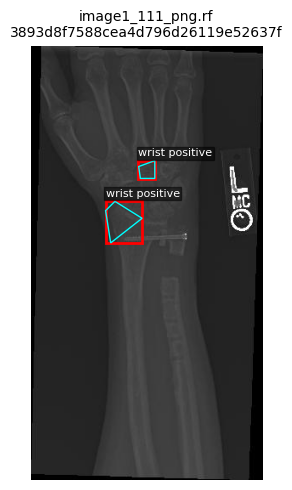

In [205]:
show_sample("image1_111_png.rf.3893d8f7588cea4d796d26119e52637f")

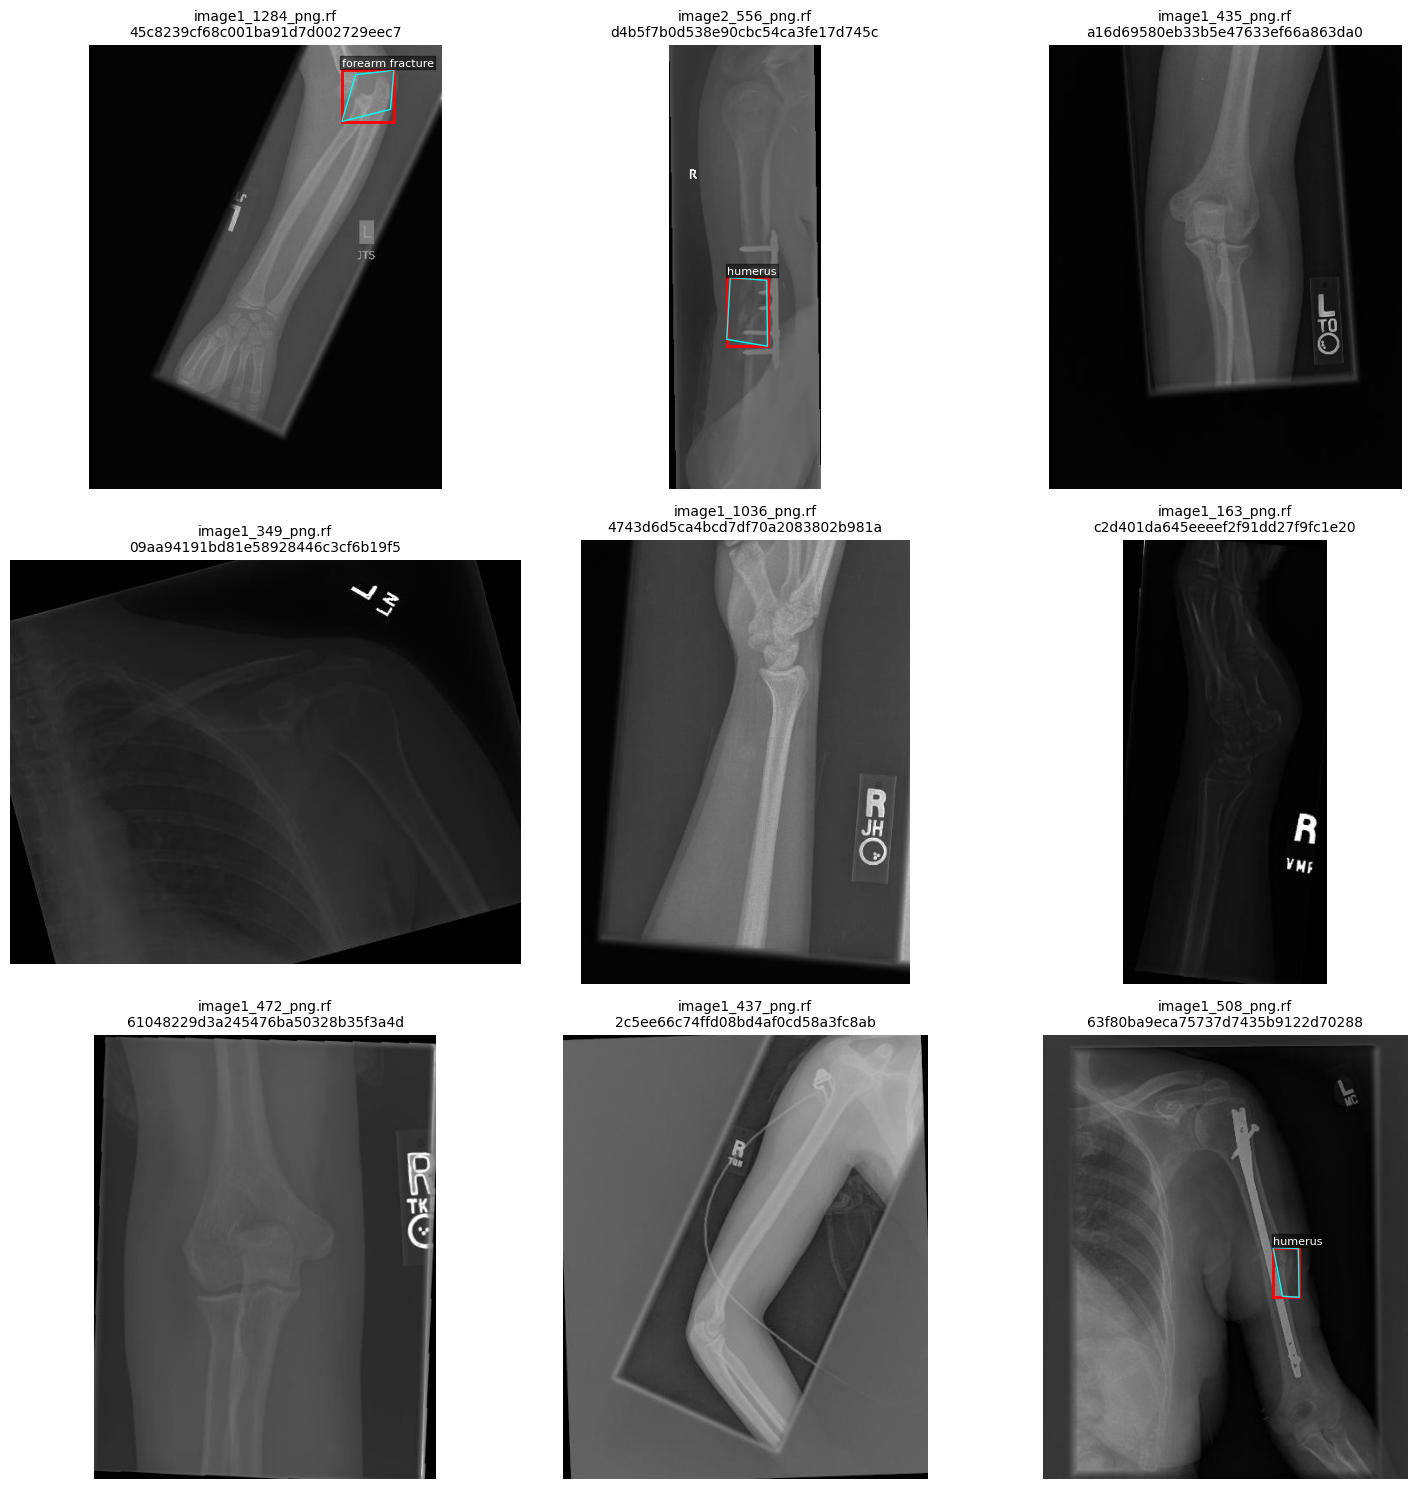

In [206]:
show_samples(df["name"].sample(9).to_list())